In [1]:
import sys
import string
import json
import requests

from flowmaps.flowmaps import FlowMaps
from flowmaps import plot

import pytz
from datetime import datetime, timezone, timedelta

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress

import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
API_URL = "https://flowmaps.life.bsc.es/api"


def fetch_all_pages(collection, query={}, batch_size=1000, projection={}):
    base_url = API_URL
    url = f"{base_url}/{collection}"
    params = {'where': json.dumps(query), 'max_results': batch_size, 'projection': json.dumps(projection)}
    data = []
    response = requests.get(url, params=params).json() # get first page
    data.extend(response['_items'])
    if '_links' not in response:
        return data
    num_docs = response['_meta']['total']
    if num_docs <= 0:
        return data
    while 'next' in response['_links']:
        print('.', end='')
        url = f"{base_url}/{response['_links']['next']['href']}"
        response = requests.get(url).json()
        data.extend(response['_items'])
    return data


def get_date(date_strn):
    date = datetime.strptime(date_strn, '%Y-%m-%d')
    start_summer_time = datetime(date.year, 3, 29) # Spanish summer time
    end_summer_time = datetime(date.year, 10, 25)
    if start_summer_time <= date <= end_summer_time:
        delta_h = timedelta(hours=2)
    else:
        delta_h =  timedelta(hours=1)
    date -= delta_h
    return date


def date_rfc1123(date_strn):
    """Return a string representation of a date according to RFC 1123
    (HTTP/1.1).

    The supplied date must be in UTC.

    """
    dt = get_date(date_strn)
    weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][dt.weekday()]
    month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep",
             "Oct", "Nov", "Dec"][dt.month - 1]
    return "%s, %02d %s %04d %02d:%02d:%02d GMT" % (weekday, dt.day, month,
        dt.year, dt.hour, dt.minute, dt.second)



def get_mitma_odm(date_str):
    filters = {'date': date_str, 'source_layer': 'mitma_mov', 'target_layer': 'mitma_mov' }
    df = pd.DataFrame(fetch_all_pages('mitma_mov.daily_mobility_matrix', filters))
    return df


def get_ine_odm(date_strn):
    date = date_rfc1123(date_strn)
    print(date)
    filters = {'evday': date }
    df = pd.DataFrame(fetch_all_pages('ine_mov.movements', filters))
    df = df.rename({'origen':'source', 'destino':'target', 'flujo':'trips'}, axis=1)
    return df


def get_mitma_zones():
    muni2trans = pd.DataFrame(fetch_all_pages('mitma_mov.muni2trans'))
    muni2trans = muni2trans[['id_grupo_t', 'cpro']].drop_duplicates()
    cnig_provincia = pd.DataFrame(fetch_all_pages('cnig.provincias')).drop('_id', axis=1)
    mitma_zones = pd.DataFrame(fetch_all_pages('layers', {'layer': 'mitma_mov'}))
    mitma_geojson_dict = dict(zip(mitma_zones['id'], mitma_zones['feat']))
    mitma_zones['x'] = mitma_zones.centroid.map(lambda x: x[0])
    mitma_zones['y'] = mitma_zones.centroid.map(lambda x: x[1])
    mitma_zones = mitma_zones.drop(['feat', 'centroid', '_id', 'layer'], axis=1)
    mitma_zones = mitma_zones.sort_index()
    mitma_zones = pd.merge(mitma_zones, muni2trans, left_on='id', right_on='id_grupo_t')
    mitma_zones = pd.merge(mitma_zones, cnig_provincia, left_on='cpro', right_on='cod_prov').set_index('id')
    return mitma_zones


def get_overlaps(layerl, layerm, collection='layers.overlaps'):
    docs = fetch_all_pages(collection, {'l.layer': layerl, 'm.layer': layerm})
    flatten_docs = []
    for doc in docs:
        d = {}
        d['l_layer'] = doc['l']['layer']
        d['m_layer'] = doc['m']['layer']
        d['l_ratio'] = doc['l']['ratio']
        d['m_ratio'] = doc['m']['ratio']
        d['l_id'] = doc['l']['id']
        d['m_id'] = doc['m']['id']
        flatten_docs.append(d)
    return flatten_docs

In [2]:
zones_mapping = get_mitma_zones()

............

In [3]:
def compare_ine2mitma(date):
    df_mitma_odm = get_mitma_odm(date)
    df_ine_odm = get_ine_odm(date)
    
    mitma_ids = set(df_ine2mitma.mitma_id)
    mask = df_mitma_odm['target'].isin(mitma_ids) & df_mitma_odm['source'].isin(mitma_ids)
    df_mitma_odm = df_mitma_odm[mask]

    ine_ids = set(df_ine2mitma.index)
    mask = df_ine_odm['source'].isin(ine_ids) & df_ine_odm['target'].isin(ine_ids)
    df_ine_odm = df_ine_odm[mask]

    for i in ['source', 'target']:
        df_ine_odm = pd.merge(df_ine_odm, df_ine2mitma, left_on=i, right_index=True)
        df_ine_odm = df_ine_odm.drop(i, axis=1).rename({'mitma_id': i}, axis=1)
    df_ine_odm = df_ine_odm[['source', 'target', 'trips']]
    
    ine_odm_dict = {}
    for i,j,t in df_ine_odm[['source', 'target', 'trips']].values:
        ine_odm_dict[(i,j)] = t

    mitma_odm_dict = {}
    for i,j,t in df_mitma_odm[['source', 'target', 'trips']].values:
        mitma_odm_dict[(i,j)] = t

    common_od = set(ine_odm_dict.keys()) & set(mitma_odm_dict.keys())

    data = []
    for i,j in common_od:
        ine_t = ine_odm_dict[(i,j)]
        mitma_t = mitma_odm_dict[(i,j)]
        data.append([i, j, mitma_t, ine_t])

    df_odm_compare = pd.DataFrame(data, columns=['source', 'target', 'mitma_trips', 'ine_trips'])
    return df_odm_compare


def aggregate_by_geolayer(df, zones_mapping, col_name):
    if col_name not in {'cod_prov', 'cod_ca'}:
        return df
    df = df.copy()
    for i in ['source', 'target']:
        df = pd.merge(df, zones_mapping[col_name], left_on=i, right_index=True)
        df = df.drop(i, axis=1).rename({col_name: i}, axis=1)
        df = df[['source', 'target', 'mitma_trips', 'ine_trips']]
    df = df.groupby(['source', 'target']).aggregate({'mitma_trips': sum, 'ine_trips': sum}).reset_index()
    return df


def RMSE(x, y):
    return np.sqrt(((x - y) ** 2).mean())


## Comaparing data respect to INE

In [12]:
df_ine2mitma = pd.DataFrame(get_overlaps('mitma_mov', 'ine_mov', collection='layers.overlaps'))
df_ine2mitma = df_ine2mitma[df_ine2mitma['l_ratio'] > 0.9]
df_ine2mitma = df_ine2mitma[df_ine2mitma['m_ratio'] > 0.9]
df_ine2mitma = df_ine2mitma[['l_id','m_id']].rename({'l_id':'mitma_id', 'm_id': 'ine_id'}, axis=1)
df_ine2mitma = df_ine2mitma.set_index('ine_id')

In [13]:
selected_dates = ['2020-03-20', '2020-04-20', '2020-05-20', '2020-06-20']
odm_compare_dict = {}
for date in selected_dates:
    print(date)
    odm_compare_dict[date] = compare_ine2mitma(date)

2020-03-20
............................................................................................................................................................................................................................Thu, 19 Mar 2020 23:00:00 GMT
...............................2020-04-20
....................................................................................................................................................................................................................................Sun, 19 Apr 2020 22:00:00 GMT
.............................2020-05-20
.....................................................................................................................................................................................................................................................................................Tue, 19 May 2020 22:00:00 GMT
................................................2020-06-20
.................................

district
	2020-03-20  R^2 0.79  p-value 0.00E+00  N=19181 slope=9.64
	2020-04-20  R^2 0.80  p-value 0.00E+00  N=18752 slope=10.57
	2020-05-20  R^2 0.83  p-value 0.00E+00  N=27284 slope=10.34
	2020-06-20  R^2 0.83  p-value 0.00E+00  N=31390 slope=10.19
cod_prov
	2020-03-20  R^2 0.99  p-value 1.27E-203  N=207 slope=11.94
	2020-04-20  R^2 1.00  p-value 1.06E-216  N=214 slope=13.08
	2020-05-20  R^2 1.00  p-value 8.74E-240  N=235 slope=11.79
	2020-06-20  R^2 1.00  p-value 1.60E-244  N=239 slope=11.37
cod_ca
	2020-03-20  R^2 1.00  p-value 7.97E-74  N=70 slope=11.68
	2020-04-20  R^2 1.00  p-value 2.59E-77  N=72 slope=12.40
	2020-05-20  R^2 1.00  p-value 3.76E-84  N=75 slope=11.30
	2020-06-20  R^2 1.00  p-value 2.23E-82  N=74 slope=10.86


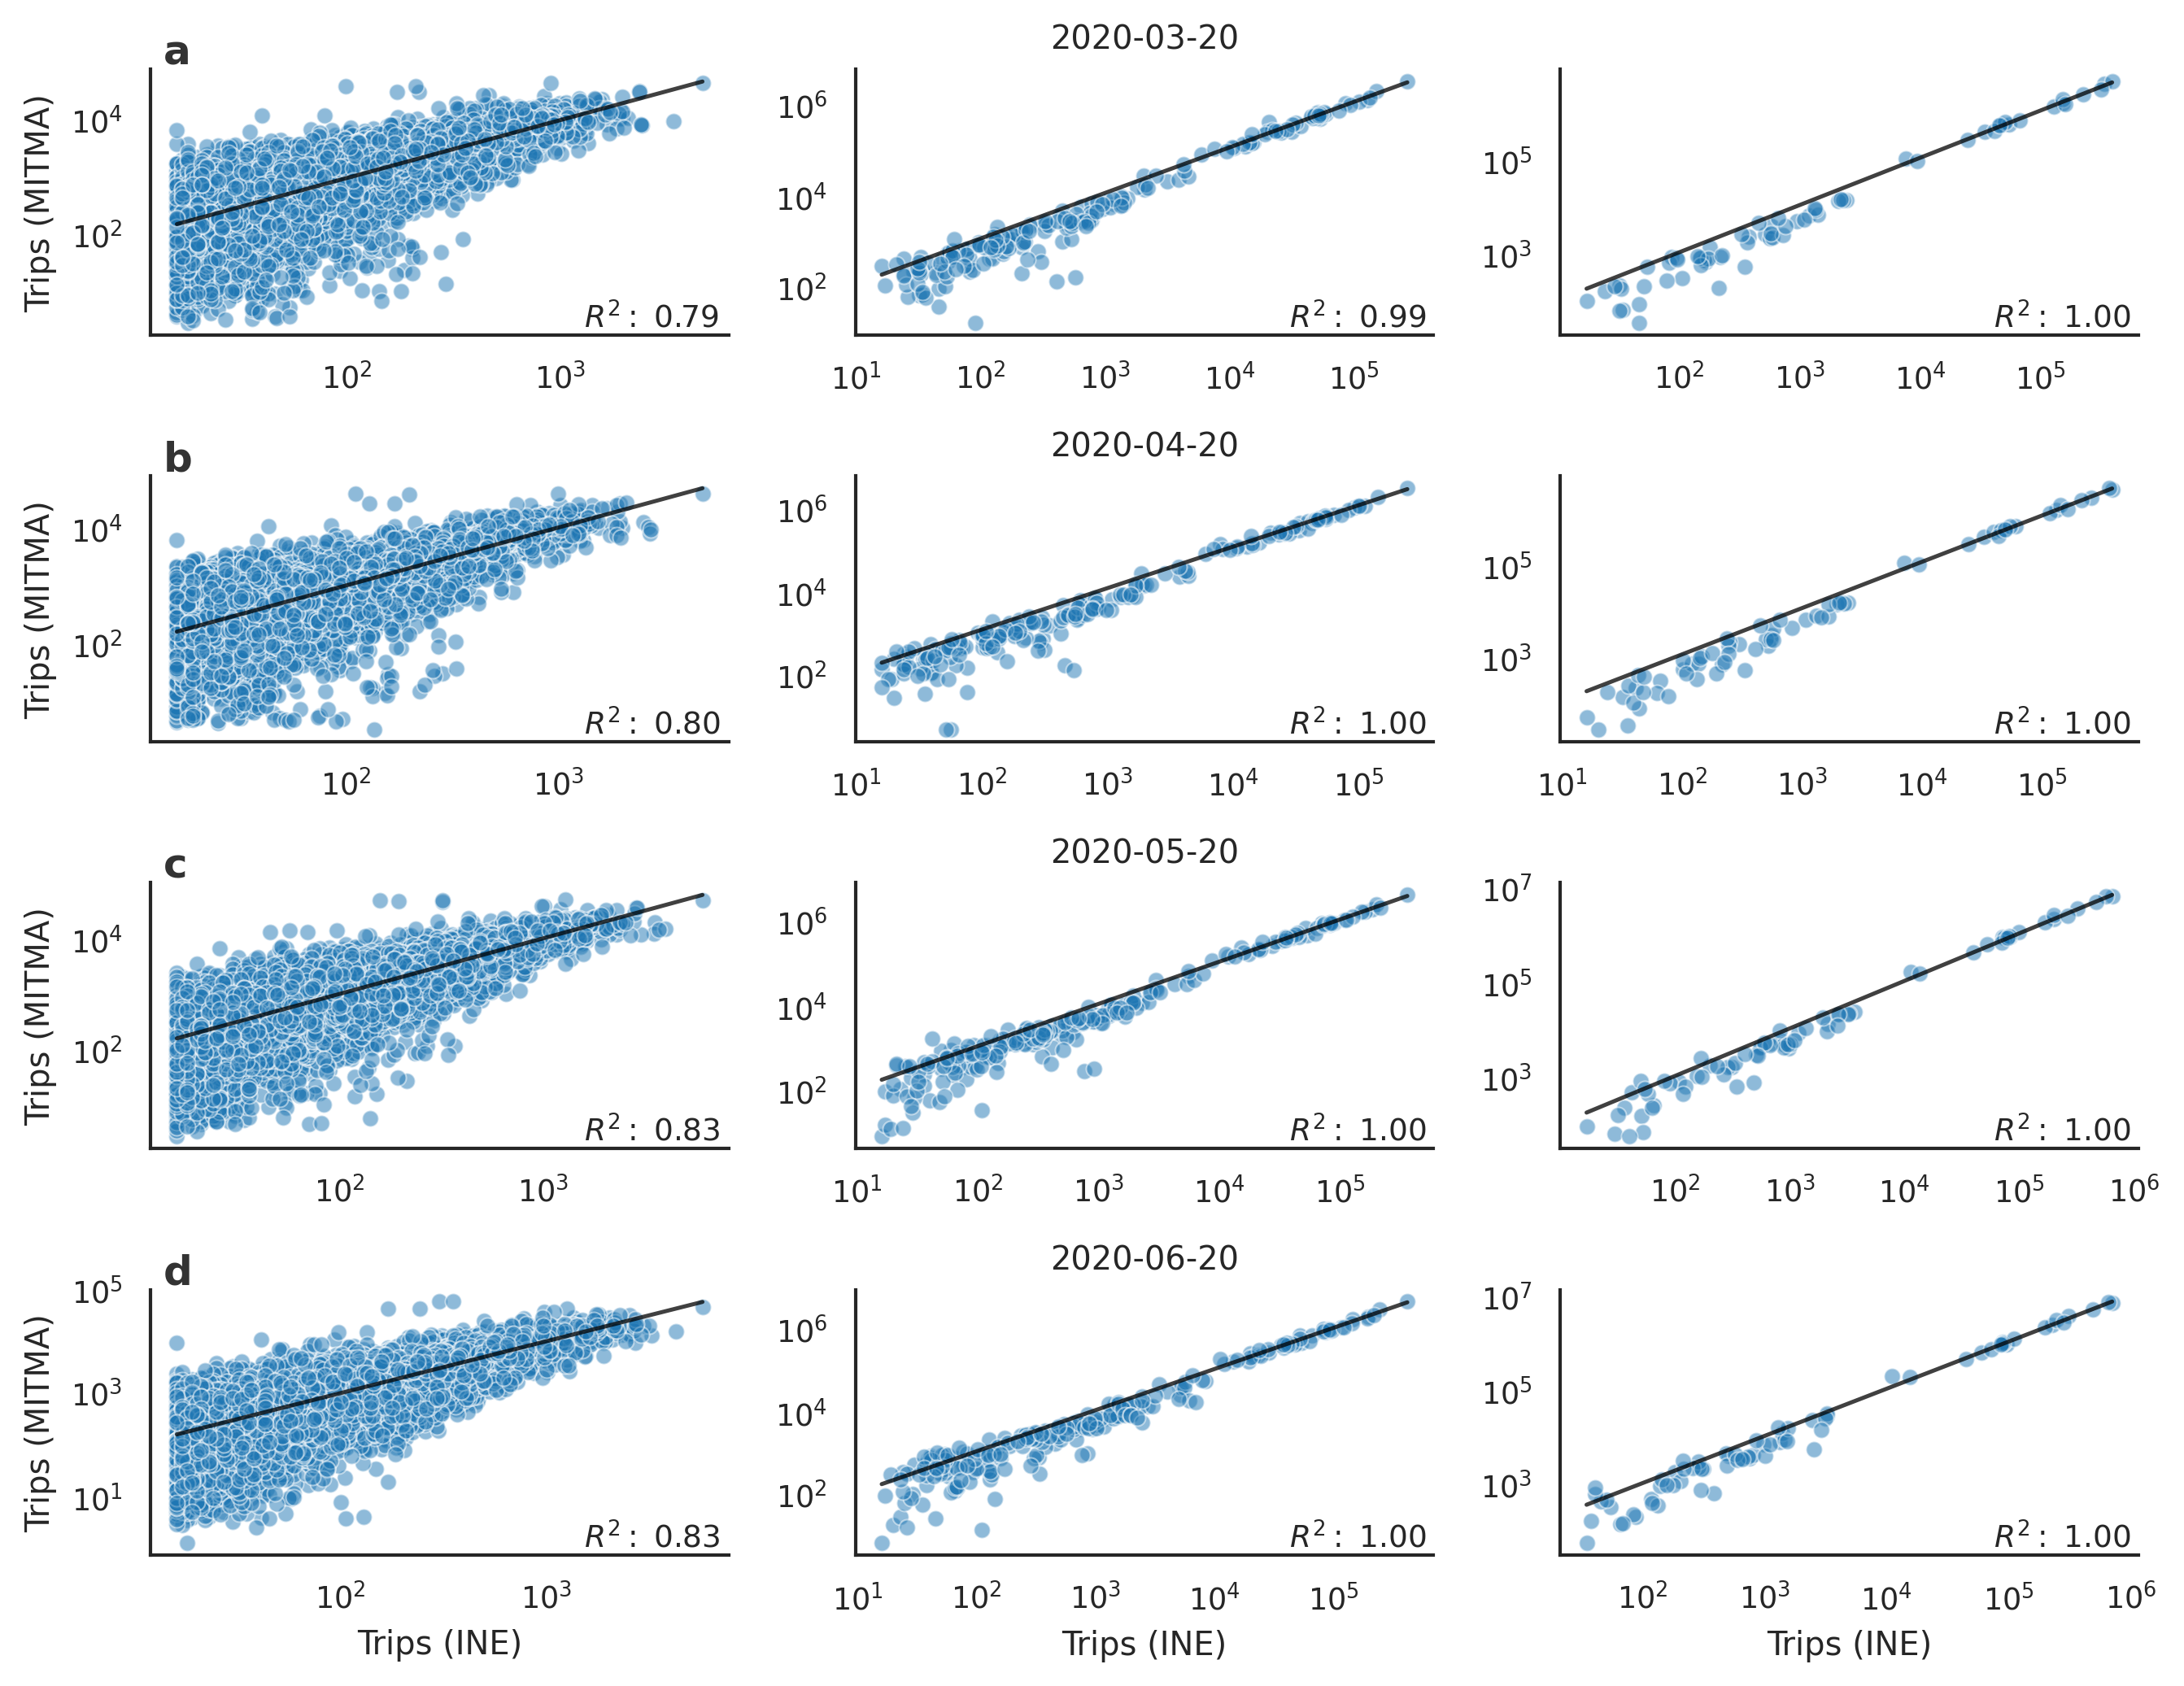

In [14]:
sns.set_style('white')
sns.set_context('paper')
fig, axes = plt.subplots(4,3, figsize=(9,7), dpi=300)

for j,geolayer in enumerate(['district', 'cod_prov', 'cod_ca']):
    print(geolayer)
    for i,date in enumerate(selected_dates):
        df_odm_compare = aggregate_by_geolayer(odm_compare_dict[date], zones_mapping, geolayer)
    
        X = df_odm_compare['ine_trips']
        y = df_odm_compare['mitma_trips']
        r,p = pearsonr(X, y)
        res = linregress(X, y)
        y_predicted = X * res.slope
        print("\t%s  R^2 %.2f  p-value %.2E  N=%i slope=%.2f" % (date, r, p, df_odm_compare.shape[0], res.slope))

        ax = axes[i,j]
        ax.scatter(X, y, alpha=0.5, edgecolor='w', linewidth=0.5)
        if i==3:
            ax.set_xlabel('Trips (INE)')
        if j==1:
            ax.set_title(date)
        if j==0:
            ax.set_ylabel('Trips (MITMA)')
            ax.text(0.022, 1.02, string.ascii_lowercase[i], fontsize=12, 
                transform=ax.transAxes, weight='bold', color='#333333')
        
        ax.plot(sorted(X), sorted(y_predicted), c='k', alpha=0.75)        
        ax.text(0.75, 0.028, r'$R^2:$ %.2f' % r, fontsize=9, transform=ax.transAxes)
        ax.set(xscale="log", yscale="log")
        
fig.tight_layout()
sns.despine(fig)
fig.savefig('../out/Figure_6.png')